In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KernelDensity

def kdensity_smoothed_histogram(x):
    t = np.linspace(np.min(x), np.max(x),100)
    p = kdensity(x)(t)
    return t,p

def kdensity(x):
    import numbers
    if len(x.shape)!=1:
       raise ValueError("x must be a vector. found "+str(x.shape)+" dimensions")
    stdx = np.std(x)
    bw = 1.06*stdx*len(x)**-.2 if stdx!=0 else 1.
    kd = KernelDensity(bandwidth=bw)
    kd.fit(x.reshape(-1,1))

    func = lambda z: np.exp(kd.score_samples(np.array(z).reshape(-1,1)))
    return func

# Distances in the Euclidean space vs number of dimensions

## 1. Distributions of distances to the origin

we have a $d$-dimensional space and we sample points in that space from a uniform distribution so that any point $x$:

$$X = [x_0, ..., x_{d-1}] \in [0,1]^d\;\;\;\;\;\;\;\;\; \;x_i \sim \; \mathbf{U}(0,1) \;\;\;\;\;\;\;\;\; x_i\;iid\;x_j$$

the squared Euclidean distance of a point to the origin is given by

$$d_x^2 = x_0^2 + x_1^2 + ... + x_{d-1}^2$$

and the random variable $d_x^2$ is distributed normally according to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). We now want to **obtain the distribution of $d_x^2$** and inspect it.

Observe that if $X$ is a random variable, whose CDF is $F_x$ and PDF $P_x$, and $Y=X^2$ then

$F_y(y) = P_y(Y\le y) = P_x(X^2\le y) = P_x(-\sqrt{y}\le X \le \sqrt{y}) = P_x (X\le \sqrt{y}) - P_x(X\le -\sqrt{y}) = F_x(\sqrt{y}) - F_x(\sqrt{y})$

Also, recall that the PDF of a distribution is the derivative of the CDF: $\frac{d}{dx}F_x(x) = P(x)$

For $x\sim \mathbf{U}(0,1)$, then $F_x(x)=x$ and $P(x)=1$ if $x\in [0,1]$ and $0$ elsewhere. Therefore, for $y=x^2$, $F_y=\sqrt{y}$ and $P_y=\frac{1}{2\sqrt{y}}$

The expected value of $y$:

$$E[y] = \int_0^1 yP_y(y)dy = \int_0^1y\frac{1}{2\sqrt{y}}dy = \int_0^1\frac{1}{2}\sqrt{y}dy = \frac{1}{3}y^{3/2} \bigg\rvert_0^1 = \frac{1}{3}$$

And its standard deviation $E[(y-\frac{1}{3})^2] = \frac{2}{3\sqrt{5}} \approx 0.2981$

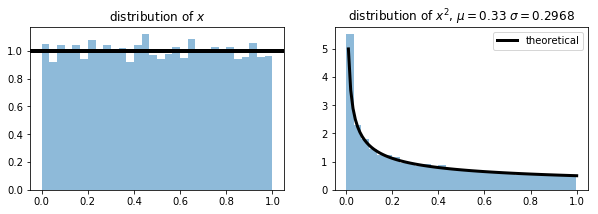

In [5]:
x = np.random.random(10000)
np.std(x), np.std(x**2), np.mean(x**2)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(x, bins=30, alpha=.5, normed=True);
plt.axhline(1, label="theoretical", color="black", lw=4)
plt.title("distribution of $x$")
plt.subplot(122)
plt.hist(x**2, bins=30, normed=True, alpha=.5);
t = np.linspace(0.01,1,100)
plt.plot(t, .5/np.sqrt(t), color="black", lw=3, label="theoretical")
plt.title("distribution of $x^2$, $\mu=%.2f$ $\sigma=%.4f$"%(np.mean(x**2), np.std(x**2)))
plt.legend()

Following the central limit theorem:

$$\sqrt{d}\Bigg( \Bigg(\frac{1}{d} \sum_{i=0}^{d-1}x_i^2   \Bigg) - \mu \Bigg) \sim \mathcal{N}(0,\sigma)$$

so, 
$$d_x^2 = \sum x_i^2 \sim \mathcal{N}(d\mu, \sqrt{d}\sigma)$$

and having $\mu = \frac{1}{3}$ and $\sigma = \frac{2}{3\sqrt{5}}$, therefore
$$d_x^2 \sim \mathcal{N}(\frac{1}{3}d, \frac{2\sqrt{d}}{3\sqrt{5}})$$

now that we characterized the distribution of the distance squared depending on the space dimensionality $d$

(0, 15)

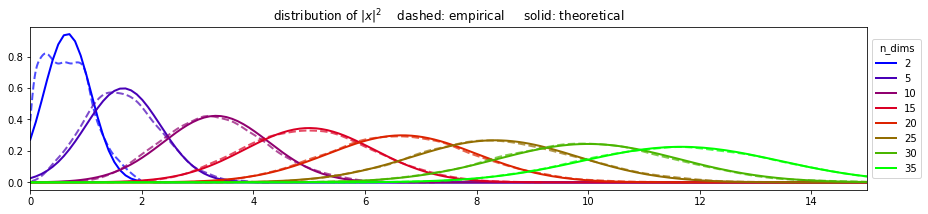

In [6]:
dim_range = np.array([2] + range(0,40,5)[1:])
plt.figure(figsize=(15,3))
n=10000
for i,d in enumerate(dim_range):
    
    x = np.random.random(size=(n,d))
    color = plt.cm.brg(255*i/(len(dim_range)-1))
    t,p = kdensity_smoothed_histogram(np.sum(x**2, axis=1))
    plt.plot(t,p,lw=2, color=color, alpha=.7, ls="--")
    
    mu = d/3.
    sigma = 2*np.sqrt(d)/3./np.sqrt(5)
    t = np.linspace(0,20,200)
    plt.plot(t, stats.norm(loc=mu, scale=sigma).pdf(t), label=str(d), lw=2, color=color)
    
plt.legend(loc='center left', bbox_to_anchor=(1, .5), title="n_dims")
plt.title("distribution of $|x|^2$    dashed: empirical     solid: theoretical")
plt.xlim(0,15)

**CONCLUSION**: as the number of dimensions increases data drifts away from the origin

## 2. Distances between random points

take a sample on $d$ dimensions from uniform distribution (0,1), compute distances among all points and plot smoothed histogram.

in this case, we take a brute force approach if we do not go through the effort of deriving the distributions analytically as previously

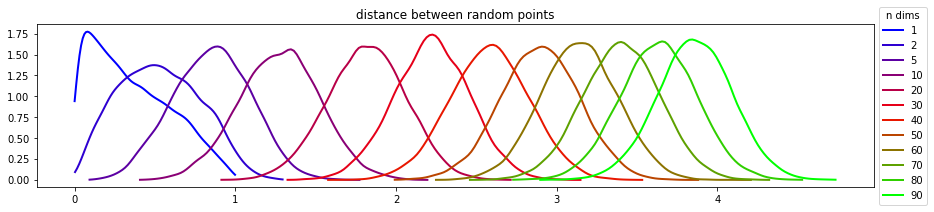

In [7]:
n = 200
dim_range = np.array([1,2,5] + range(0,100,10)[1:])
plt.figure(figsize=(15,3))

for i,d in enumerate(dim_range):
    color = plt.cm.brg(255*i/(len(dim_range)-1))
    x = np.random.random(size=(n,d))
    distances = np.r_[[np.linalg.norm(x[i]-x[j]) for i in range(len(x)) for j in range(i+1, len(x))]]
    t,p = kdensity_smoothed_histogram(distances)
    plt.plot(t,p,lw=2, label=str(d), color=color)
plt.legend(loc="center left", bbox_to_anchor=(1,.5), title="n dims")   
plt.title("distance between random points")

**CONCLUSION**: as the number of dimensions increases points get further away from eachother

## 3. Volume of the inscribed unit hypersphere

we sample again in $d$ dimensions from the uniform distribution (0,1). This is, we sample points in the unit hypercube. What percentage of the sample points fall within the inscribed hypersphere?

The volume of a hypercube of side 1 is 1.

The volume of a hypersphere of radius $R$ in $d$ dimensions is 

$$V_d = \frac{\pi^{d/2}}{\Gamma\Big(\frac{d}{2}+1\Big)}R^n$$

with $R=\frac{1}{2}$

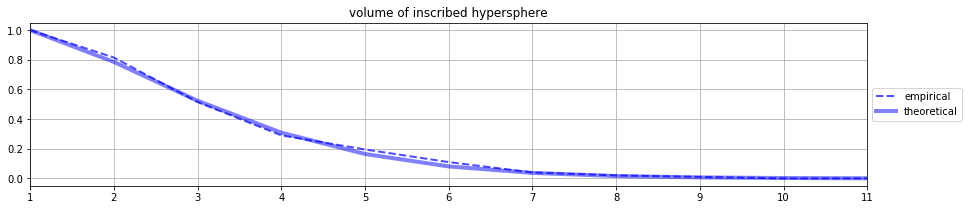

In [8]:
import scipy

n = 200
dim_range = np.arange(1,12,1)
plt.figure(figsize=(15,3))

r,t = [],[]
for d in dim_range:
    x = np.random.random(size=(n,d))
    s = np.sqrt((x**2).sum(axis=1))
    r.append(np.mean(s<=1))
    t.append((np.pi**(d/2.))/scipy.special.gamma(d/2.+1)*.5**d)
    
plt.plot(dim_range, r, lw=2, alpha=.7, label="empirical", ls="--", color="blue")
plt.plot(dim_range, t, lw=4, alpha=.5, label="theoretical", color="blue")
plt.legend(loc="center left", bbox_to_anchor=(1,.5))   
plt.title("volume of inscribed hypersphere")
plt.xlim(1,np.max(dim_range))
plt.xticks(dim_range);
plt.grid()

**CONCLUSION**: as the number of dimensions increases the **inscribed** unit hypersphere becomes insignificantly small